In [1]:
import numpy as np
import pandas as pd
import ast 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [19]:
df = pd.read_csv('eval_features.csv')
df.sample(5)

,filename,head_movement,feature_lengths,flicker,blink,lip_movement_variance,ssim,psnr,pulse,fake
11,15.mp4,"[0.3290700316429138, 0.3290700316429138, -1.12...","[45.0, 5.0, 5.0, 50.0, 50.0, 45.0, 45.0]","[-0.6594973802566528, 1.2087688446044922, -1.0...","[2.0, 0.0, 4.0, 0.0, 0.0]","[0.7197502851486206, 0.5604246854782104, 0.733...","[0.5490731596946716, -1.3766738176345825, 1.02...","[0.30349522829055786, -1.0884894132614136, 0.9...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
0,20.mp4,"[-0.6548720002174377, -0.6548720002174377, 0.4...","[45.0, 5.0, 5.0, 50.0, 50.0, 45.0, 45.0]","[-0.8597586154937744, 0.6819965839385986, -0.8...","[0.0, 0.0, 2.0, 0.0, 0.0]","[0.9312403798103333, 0.9252268671989441, 0.414...","[1.0133568048477173, -0.9049534797668457, 0.98...","[0.8175595998764038, -0.8274472951889038, 0.73...","[-0.851137101650238, -0.851137101650238, -1.49...",1
32,11.mp4,"[-0.03143012896180153, 0.432781845331192, -1.7...","[45.0, 5.0, 5.0, 50.0, 50.0, 45.0, 45.0]","[-0.7935228943824768, 1.8584328889846802, -0.8...","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.8043959736824036, 0.9093046188354492, 1.324...","[0.8854838609695435, -1.457051157951355, 1.074...","[0.6680983304977417, -1.2342485189437866, 1.62...","[-0.35128769278526306, -0.5982029438018799, -0...",0
16,4.mp4,"[0.08941064029932022, 0.08941064029932022, 1.4...","[45.0, 5.0, 5.0, 50.0, 50.0, 45.0, 45.0]","[-0.8822747468948364, 0.9875002503395081, -0.8...","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.8082144260406494, 0.9941520690917969, 0.774...","[0.9113782644271851, -1.0526565313339233, 0.89...","[0.9224672913551331, -0.9455851912498474, 0.85...","[0.8097513318061829, 0.8097513318061829, -0.68...",1
18,18.mp4,"[-0.4684832990169525, -0.341494083404541, -1.2...","[45.0, 5.0, 5.0, 50.0, 50.0, 45.0, 45.0]","[-0.8309661149978638, 1.596960186958313, -1.00...","[4.0, 0.0, 0.0, 8.0, 6.0]","[1.128739595413208, 0.8810914754867554, 0.6208...","[0.9166872501373291, -1.326309084892273, 1.103...","[0.5947515964508057, -1.104297161102295, 1.819...","[1.523289680480957, 1.5872505903244019, 0.9061...",1


In [20]:
df = df.drop(columns=["filename"])

In [21]:
# Option 1: Concatenate all features (flatten nested lists)

# Convert all columns except 'fake' from string to list
for col in df.columns:
    if col != "fake":
        df[col] = df[col].apply(ast.literal_eval)

# This flattens each row of lists into a single feature vector
X = np.array([np.concatenate(row.values) for _, row in df.drop(columns=["fake"]).iterrows()])
y = df["fake"].values

In [17]:
#option 2: summarize each list with aggregate features (mean, std, etc.)
for col in df.columns:
    if col != "fake":
        df[col] = df[col].apply(ast.literal_eval)

agg_df = df.copy()
for col in df.columns:
    if col != "fake":
        agg_df[f"{col}_mean"] = df[col].apply(np.mean)
        agg_df[f"{col}_std"] = df[col].apply(np.std)
        agg_df[f"{col}_max"] = df[col].apply(np.max)
        agg_df[f"{col}_min"] = df[col].apply(np.min)

# drop the original list-based columns
agg_df = agg_df.drop(columns=[col for col in df.columns if col != "fake"])

# final X and y
X = agg_df.drop(columns=["fake"]).values
y = agg_df["fake"].values

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.7, random_state=27)

In [23]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Function to run model

In [30]:
def evaluate_model(model, model_name):
    print(f"Training {model_name}...")
    
    # Fit model
    model.fit(X_train, y_train)
    
    # Predict on test data
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC (probabilities for positive class)
    
    target_names = ["Authentic", "Deepfake"]
    
    # Calculate accuracy, AUC, and confusion matrix
    acc = metrics.accuracy_score(y_test, y_pred)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = round(metrics.auc(fpr, tpr), 2)
    cm = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=target_names)
    
    # Print the classification report for the model
    print(f"Classification Report for {model_name}:\n{class_report}\n")

    # Plot confusion matrix for the model
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(cm, annot=True, cmap='Blues_r', fmt='g', xticklabels=target_names, yticklabels=target_names, ax=ax)
    ax.set_xlabel("Predicted Values")
    ax.set_ylabel("Actual Values")
    ax.set_title(f"Confusion Matrix for {model_name}")
    plt.show()

    return acc, auc, cm

Logistic Regression

Training Logistic Regression...
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

   Authentic       0.61      0.64      0.62        22
    Deepfake       0.33      0.31      0.32        13

    accuracy                           0.51        35
   macro avg       0.47      0.47      0.47        35
weighted avg       0.51      0.51      0.51        35




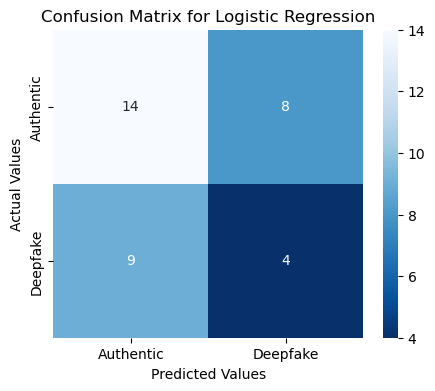

In [31]:
log_reg = LogisticRegression(solver='liblinear')
log_reg_acc, log_reg_auc, log_reg_cm = evaluate_model(log_reg, "Logistic Regression")

Decision Tree

Training Decision Tree...
Classification Report for Decision Tree:
              precision    recall  f1-score   support

   Authentic       0.67      0.45      0.54        22
    Deepfake       0.40      0.62      0.48        13

    accuracy                           0.51        35
   macro avg       0.53      0.53      0.51        35
weighted avg       0.57      0.51      0.52        35




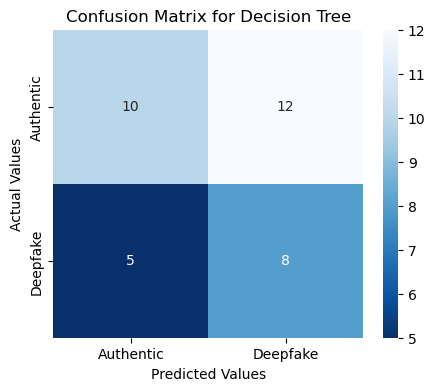

In [32]:
dt = DecisionTreeClassifier()
dt_acc, dt_auc, dt_cm = evaluate_model(dt, "Decision Tree")

Naive Bayes


Training Naive Bayes...
Classification Report for Naive Bayes:
              precision    recall  f1-score   support

   Authentic       0.50      0.18      0.27        22
    Deepfake       0.33      0.69      0.45        13

    accuracy                           0.37        35
   macro avg       0.42      0.44      0.36        35
weighted avg       0.44      0.37      0.33        35




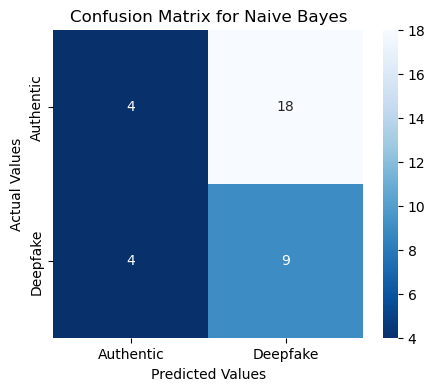

In [33]:
nb = GaussianNB()
nb_acc, nb_auc, nb_cm = evaluate_model(nb, "Naive Bayes")

K Nearest Neighbours

Training KNN...
Classification Report for KNN:
              precision    recall  f1-score   support

   Authentic       0.56      0.68      0.61        22
    Deepfake       0.12      0.08      0.10        13

    accuracy                           0.46        35
   macro avg       0.34      0.38      0.35        35
weighted avg       0.40      0.46      0.42        35




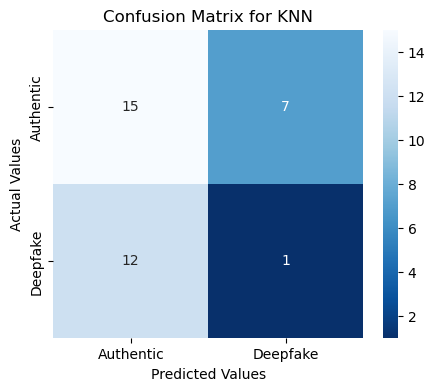

In [34]:
knn = KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree', n_jobs=-1)
knn_acc, knn_auc, knn_cm = evaluate_model(knn, "KNN")

SVM

Training SVM...
Classification Report for SVM:
              precision    recall  f1-score   support

   Authentic       0.63      1.00      0.77        22
    Deepfake       0.00      0.00      0.00        13

    accuracy                           0.63        35
   macro avg       0.31      0.50      0.39        35
weighted avg       0.40      0.63      0.49        35




c:\Users\user\anaconda3\envs\is217_env\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\anaconda3\envs\is217_env\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\anaconda3\envs\is217_env\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


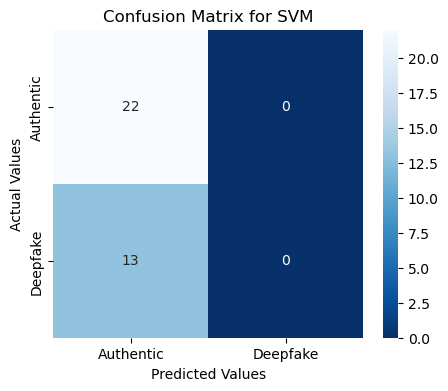

In [35]:
svm = SVC(probability=True)
svm_acc, svm_auc, svm_cm = evaluate_model(svm, "SVM")

Random Forrest

Training Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

   Authentic       0.62      0.82      0.71        22
    Deepfake       0.33      0.15      0.21        13

    accuracy                           0.57        35
   macro avg       0.48      0.49      0.46        35
weighted avg       0.51      0.57      0.52        35




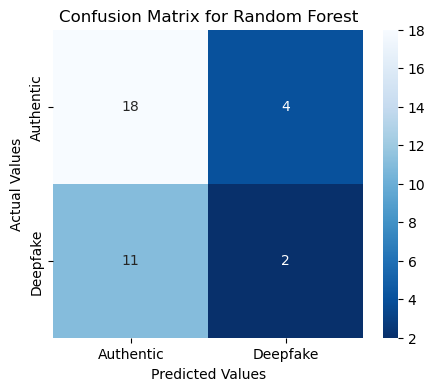

In [36]:
rf = RandomForestClassifier()
rf_acc, rf_auc, rf_cm = evaluate_model(rf, "Random Forest")

AdaBoost

Training AdaBoost...
Classification Report for AdaBoost:
              precision    recall  f1-score   support

   Authentic       0.57      0.36      0.44        22
    Deepfake       0.33      0.54      0.41        13

    accuracy                           0.43        35
   macro avg       0.45      0.45      0.43        35
weighted avg       0.48      0.43      0.43        35




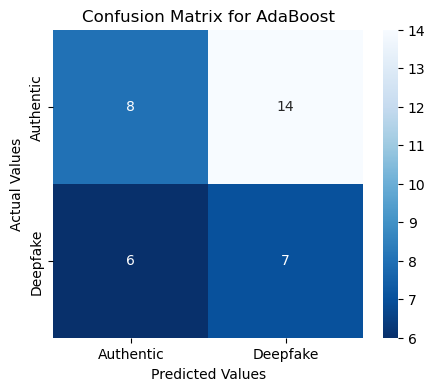

In [48]:
from sklearn.ensemble import AdaBoostClassifier

ada_model= AdaBoostClassifier(n_estimators=100, random_state=27)
ada_acc, ada_auc, ada_cm = evaluate_model(ada_model, "AdaBoost")

XGBoost

In [50]:
pip install xgboost


   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB 320.0 kB/s eta 0:07:49
   ---------------------------------------- 0.0/150.0 MB 325.1 kB/s eta 0:07:42
   ---------------------------------------- 0.1/150.0 MB 737.3 kB/s eta 0:03:24
   ---------------------------------------- 0.3/150.0 MB 1.5 MB/s eta 0:01:37
   ---------------------------------------- 0.5/150.0 MB 2.2 MB/s eta 0:01:09
   ---------------------------------------- 0.7/150.0 MB 2.6 MB/s eta 0:00:58
   ---------------------------------------- 0.9/150.0 MB 3.0 MB/s eta 0:00:51
   ---------------------------------------- 1.2/150.0 MB 3.4 MB/s eta 0:00:45
   ---------------------------------------- 1.5/150.0 MB 3.7 MB/s eta 0:00:40
   ---------------------------------------- 1.8/150.0 MB 4.0 MB/s eta 0:00:37
    --------------------------------------- 2.2/150.0 MB 4.3 MB/s eta 0

XGBoost

Training XGBoost...
Classification Report for XGBoost:
              precision    recall  f1-score   support

   Authentic       0.65      0.59      0.62        22
    Deepfake       0.40      0.46      0.43        13

    accuracy                           0.54        35
   macro avg       0.53      0.53      0.52        35
weighted avg       0.56      0.54      0.55        35




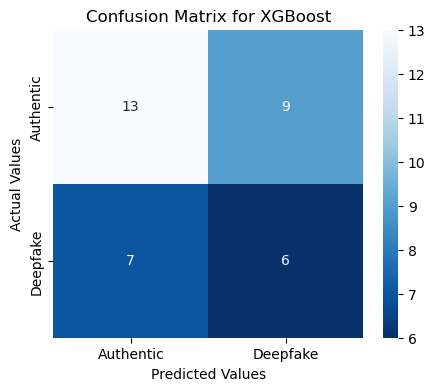

In [57]:
from xgboost import XGBClassifier
xgb =  XGBClassifier(n_estimators=100, random_state=27)
xgb_acc, xgb_auc, xgb_cm = evaluate_model(xgb, "XGBoost")

Summary of Evaluation


In [59]:
print("\nSummary of Results:")
models = ["Logistic Regression", "SVM", "KNN", "Decision Tree", "Random Forest", "Naive Bayes", "AdaBoost", "XGBoost"]
accuracies = [log_reg_acc, svm_acc, knn_acc, dt_acc, rf_acc, nb_acc, ada_acc, xgb_acc]
auc_scores = [log_reg_auc, svm_auc, knn_auc, dt_auc, rf_auc, nb_auc, ada_auc, xgb_auc]
confusion_matrices = [log_reg_cm, svm_cm, knn_cm, dt_cm, rf_cm, nb_cm, ada_cm, xgb_cm]

results = {
    "Model": models,
    "Accuracy": accuracies,
    "AUC": auc_scores,
    "Confusion Matrix": confusion_matrices
}

# Create the DataFrame
results_df = pd.DataFrame(results)

# Print the DataFrame
print(results_df)


Summary of Results:
                 Model  Accuracy   AUC    Confusion Matrix
0  Logistic Regression  0.514286  0.40   [[14, 8], [9, 4]]
1                  SVM  0.628571  0.58  [[22, 0], [13, 0]]
2                  KNN  0.457143  0.43  [[15, 7], [12, 1]]
3        Decision Tree  0.514286  0.53  [[10, 12], [5, 8]]
4        Random Forest  0.571429  0.56  [[18, 4], [11, 2]]
5          Naive Bayes  0.371429  0.45   [[4, 18], [4, 9]]
6             AdaBoost  0.428571  0.51   [[8, 14], [6, 7]]
7              XGBoost  0.542857  0.56   [[13, 9], [7, 6]]


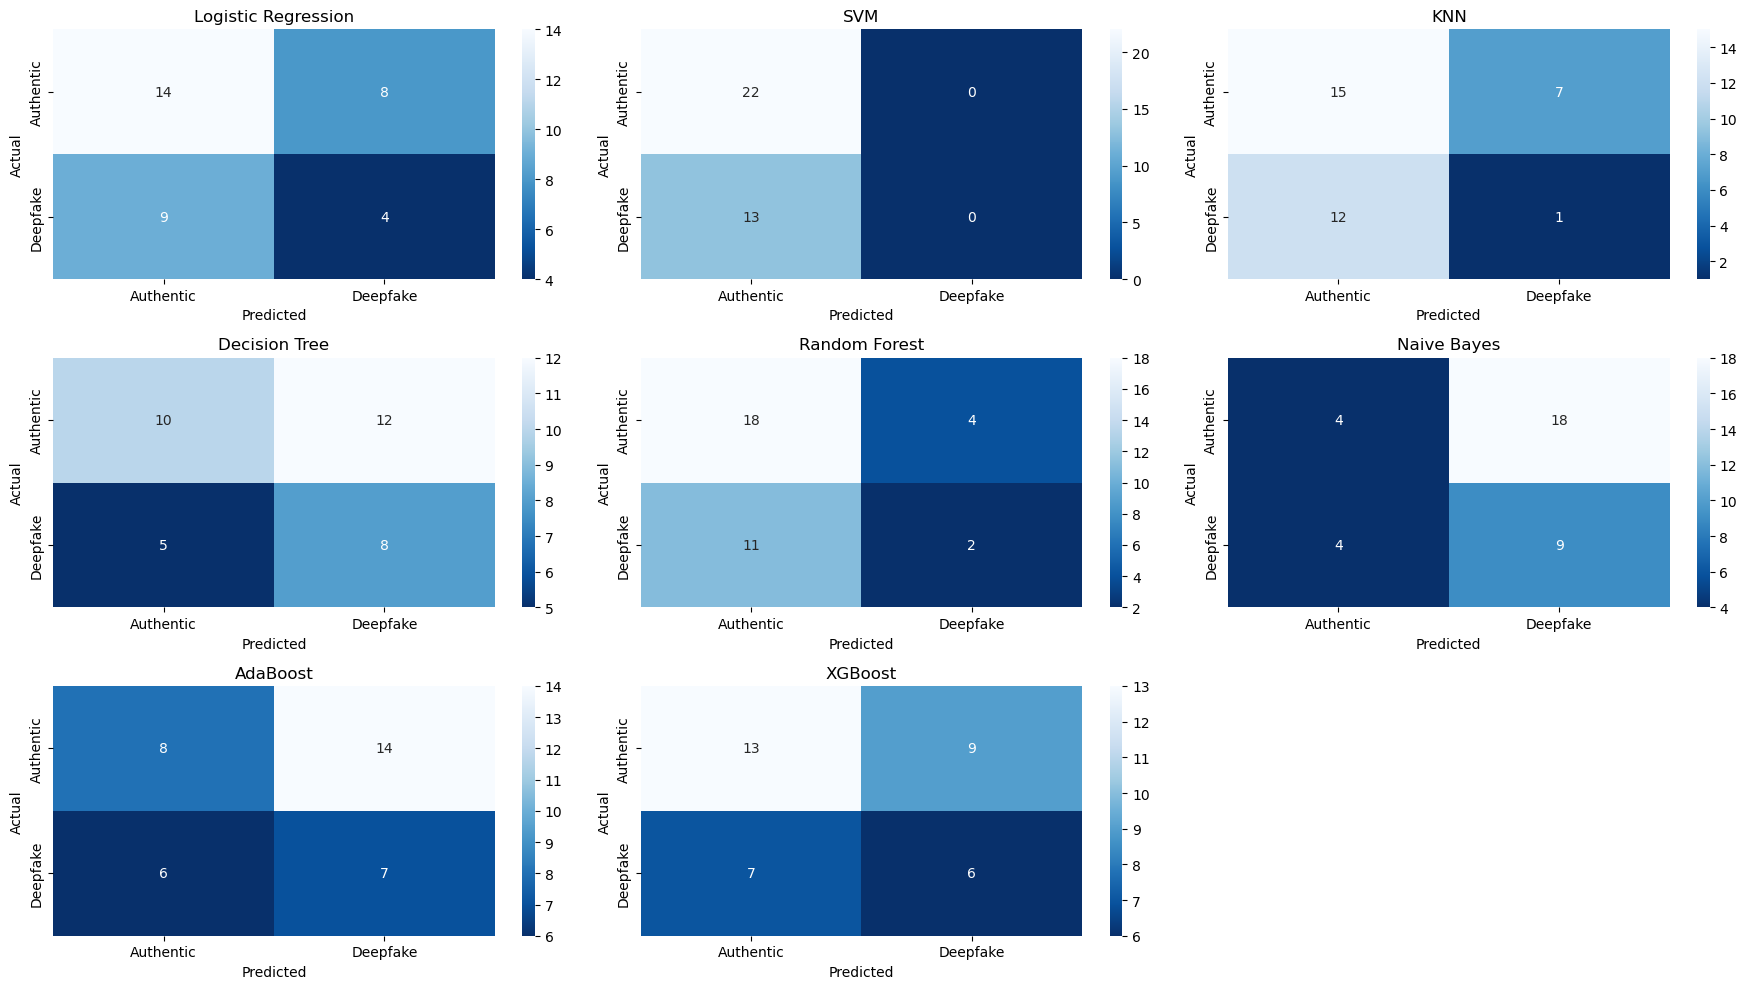

In [61]:
# List of models and their confusion matrices
models = ["Logistic Regression", "SVM", "KNN", "Decision Tree", "Random Forest", "Naive Bayes", "AdaBoost", "XGBoost"]
confusion_matrices = [log_reg_cm, svm_cm, knn_cm, dt_cm, rf_cm, nb_cm, ada_cm, xgb_cm]

# Set up the plot
plt.figure(figsize=(18, 10))  # Width x Height

target_names = ["Authentic", "Deepfake"]
    
for i, (model, cm) in enumerate(zip(models, confusion_matrices)):
    plt.subplot(3, 3, i + 1)  
    sns.heatmap(cm, annot=True, cmap='Blues_r', fmt='g', xticklabels=target_names, yticklabels=target_names)
    plt.title(model)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()